## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра. 
Анализируемый временной ряд, описывает две активности человека - бег и шаг.


In [1]:
!pip install scipy
!pip install scikit-learn

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time
import pandas as pd

In [2]:
#fixme: Путь
dataset_dir_path = Path('datasets')
data_path = dataset_dir_path/'walk_run.txt'
walk_run = np.loadtxt(data_path)[3000:4000]
data = walk_run
size_sub = 50

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

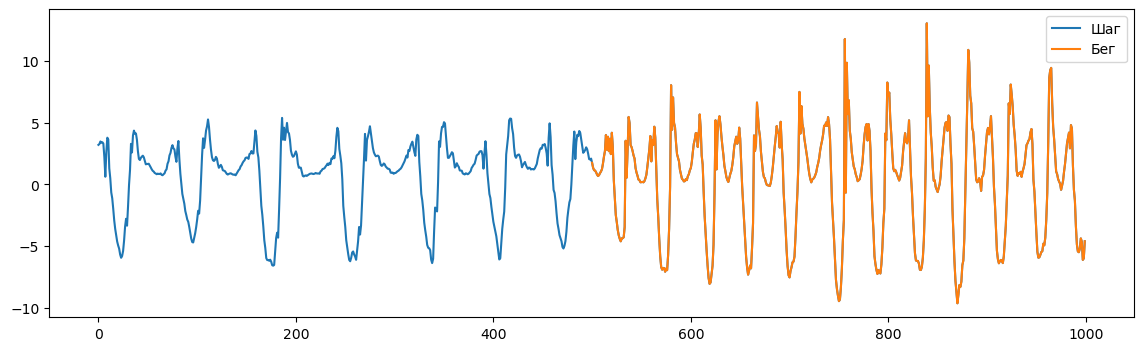

In [3]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
plt.legend()

In [4]:
result={}
times={}

##### 3.1.2 Реализация полного перебора

Приводится пример кода для нахождения топ 5 диссонансов с помощью реализации полного беребора.
Вам необходимо добавить код для сбора времени обработки данных.

In [14]:
from modules.saxpy.discord import find_discords_brute_force
start_bf = time()
discords_brute_force= np.stack(find_discords_brute_force(data[:], 50, 5))
end_bf = time()

##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [15]:
from modules.saxpy.hotsax import find_discords_hotsax

start = time()
# Запускаем HotSAX: данные, длина подпоследовательности (50), количество диссонансов (5)
discords_hotsax = np.stack(find_discords_hotsax(data[:], 50, 5))
end = time()

# Сохраняем результаты для сравнения
result['hotsax'] = discords_hotsax
times['hotsax'] = end - start
print(f"HotSAX time: {times['hotsax']:.4f} seconds")
print(f"Found discords indices: {discords_hotsax[:, 0].astype(int)}")

HotSAX time: 1.2764 seconds
Found discords indices: [477 412 195 577 278]


##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Столбчатую диаграмму времени работы обоих алгоритмов
   
Постройте графики для обоих алгоритмов и сравните полученные результаты.

Пример графика:

![first_graf](pics/fig_ex_1.png)

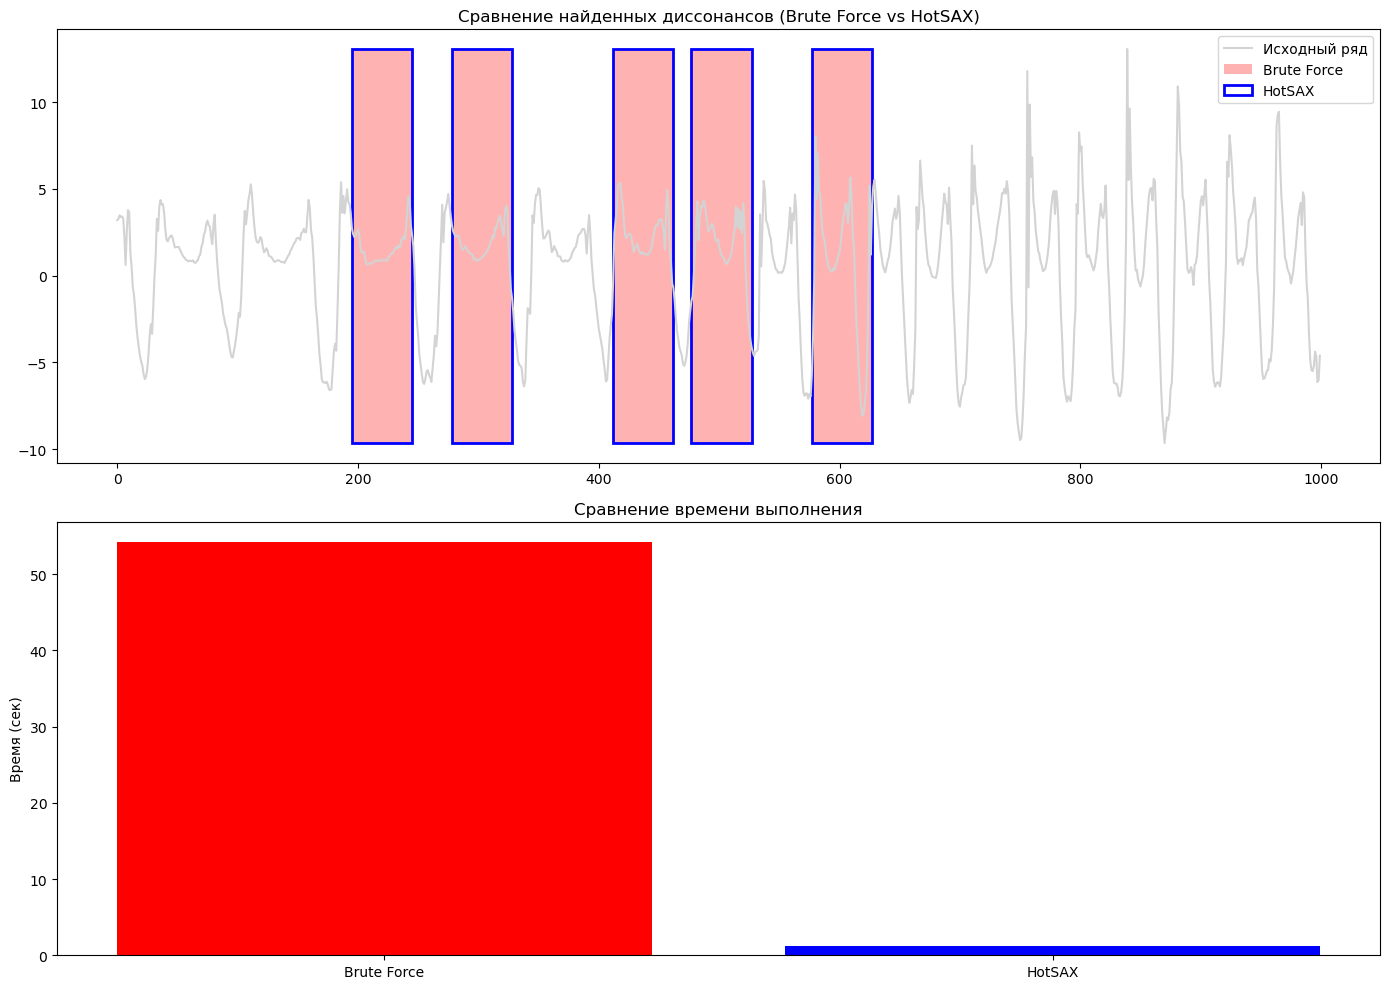

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# 1. График ряда и диссонансов
ax[0].plot(data, label='Исходный ряд', color='lightgray')
ax[0].set_title('Сравнение найденных диссонансов (Brute Force vs HotSAX)')

# Отрисовка диссонансов Brute Force (красные)
for discord in discords_brute_force:
    idx = int(discord[0])
    rect = Rectangle((idx, np.min(data)), 50, np.max(data)-np.min(data), facecolor='red', alpha=0.3, label='Brute Force')
    ax[0].add_patch(rect)

# Отрисовка диссонансов HotSAX (синие рамки, чтобы было видно наложение)
for discord in discords_hotsax:
    idx = int(discord[0])
    rect = Rectangle((idx, np.min(data)), 50, np.max(data)-np.min(data), edgecolor='blue', fill=False, lw=2, label='HotSAX')
    ax[0].add_patch(rect)

# Убираем дубликаты из легенды
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys())

# 2. Столбчатая диаграмма времени
methods = ['Brute Force', 'HotSAX']
# Предполагаем, что время для brute force сохранено в переменную (если нет, используйте сохраненные значения)
# Для примера возьмем times, если вы добавили сбор времени в 3.1.2:
times['brute_force'] = end_bf - start_bf 
# Если нет, используйте текущие переменные end-start
execution_times = [times.get('brute_force', 0), times.get('hotsax', 0)] 

ax[1].bar(methods, execution_times, color=['red', 'blue'])
ax[1].set_title('Сравнение времени выполнения')
ax[1].set_ylabel('Время (сек)')

plt.tight_layout()
plt.show()

In [5]:
from matplotlib.patches import Rectangle

##### 3.1.5 Такси NY

Произведите поиск диссонансов с помощью обоих алгоритмов на наборе данных, содержащим информацию о среднем числе пассажиров в NY. Отобразите найденные диссонансы обоими алгоритмами. 

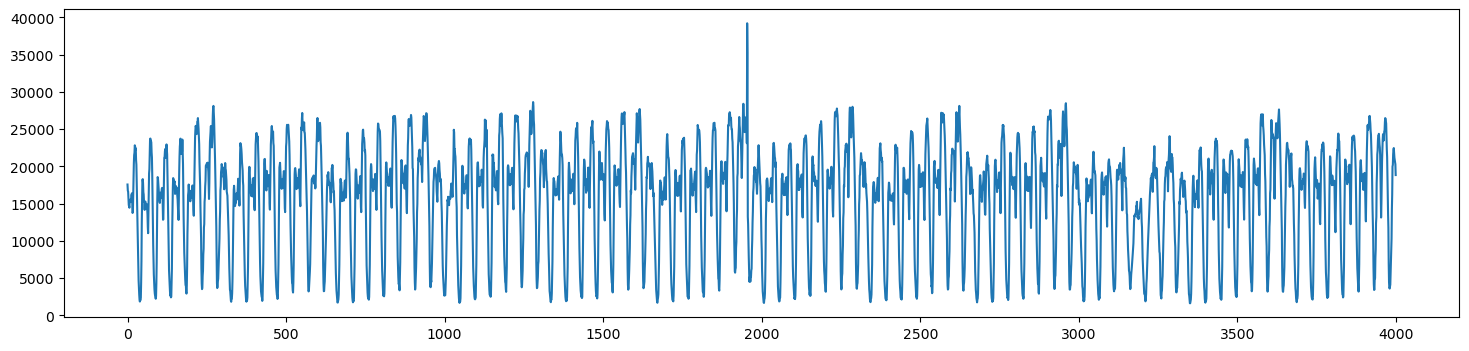

In [6]:
nyc_taxi = pd.read_csv(dataset_dir_path/'nyc_taxi.csv',index_col=0).values[4000:8000,0].astype(np.float64)
fig = plt.figure(figsize=(18, 4))
plt.plot(nyc_taxi)

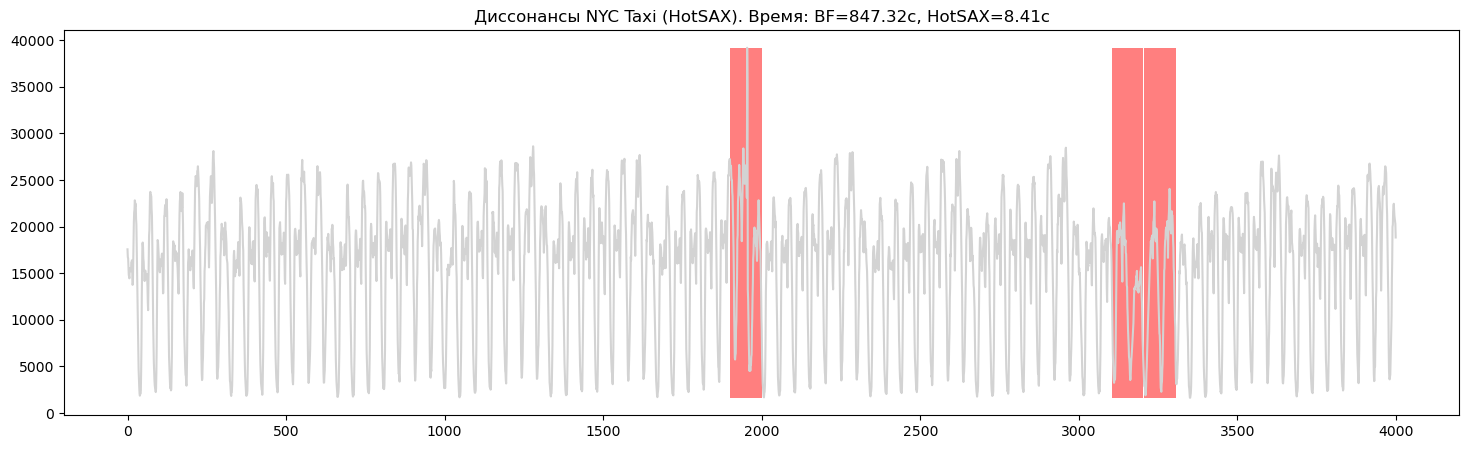

In [19]:
# Загрузка данных (используем уже загруженные nyc_taxi)
data_ny = nyc_taxi
m_ny = 100 # длина подпоследовательности (примерно полдня-день в зависимости от частоты, возьмем 100 для примера)
top_k = 3

# Brute Force
start = time()
ny_discords_bf = np.stack(find_discords_brute_force(data_ny, m_ny, top_k))
time_bf = time() - start

# HotSAX
start = time()
ny_discords_hs = np.stack(find_discords_hotsax(data_ny, m_ny, top_k))
time_hs = time() - start

# Визуализация
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(data_ny, color='lightgray', label='NYC Taxi Data')

for discord in ny_discords_hs:
    idx = int(discord[0])
    rect = Rectangle((idx, np.min(data_ny)), m_ny, np.max(data_ny)-np.min(data_ny), facecolor='red', alpha=0.5)
    ax.add_patch(rect)

ax.set_title(f'Диссонансы NYC Taxi (HotSAX). Время: BF={time_bf:.2f}c, HotSAX={time_hs:.2f}c')
plt.show()

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [7]:
!pip install stumpy==1.11.1

In [8]:
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump


C:\Users\admin\anaconda3\envs\ts_course\lib\site-packages\stumpy\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Как мы помним из лекций:

**Диапазонный диссонанс** – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога. 

Основными параметрами при поисках диссонансов являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего соседа


In [9]:
from modules.drag import find_candidates, DRAG


Для поиска диссонансов в данной части практической работы мы воспользуемся алгоритмом **DRAG (Discord Range Aware Gathering)**.
Для начала воспользуемся данным алгоритмом, чтобы найти диссонансы в наборе данных содержащем активность человека.

In [10]:
data = walk_run

Длину искомого диссонанса, как и для предыдущих алгоритмов, мы установим равно 50 точек.
Пороговое значение мы установим равным большим, чтобы узнать, как алгоритм отреагирует на большие значения данного параметра.

In [11]:
m = 50 
r = 10
idxs, _, _ = DRAG(data,m,r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 0


Как вы можете видеть мы установили слишком большое пороговое значение, алгоритму не удалось выделить ни одного диссонанса. Попробуем уменьшить пороговое значение до 1, чтобы улучшить результат. 

In [12]:
m = 50 
r = 1
idxs, _, _ = DRAG(data, m, r)
print(f'Колличество найденных диссонансов: {len(idxs)}')

Колличество найденных диссонансов: 50


При такой комбинации параметров, улучшить ситуацию не получилось. Алгоритм выделил слишком большое количество диссонансов, часть которых является ложными диссонансами и не будут информативными для нас.

Произведите подобные эксперименты с набором данных такси NY. Постройте графики демонстрирующие найденные диссонансы. Пример Графика:
![second-graph](pics/fig_ex_2.png)

In [31]:
# Загрузка данных такси NY
nyc_taxi = pd.read_csv(dataset_dir_path/'nyc_taxi.csv', index_col=0).values[4000:8000, 0].astype(np.float64)
# Сначала посмотрим на реальный диапазон расстояний
# Вычислим матрицу профилей для понимания масштаба
m = 50
mp = stumpy.stump(nyc_taxi, m)

print(f"Статистика расстояний до ближайших соседей:")
print(f"Минимум: {mp[:, 0].min():.4f}")
print(f"Максимум: {mp[:, 0].max():.4f}")
print(f"Среднее: {mp[:, 0].mean():.4f}")
print(f"Медиана: {np.median(mp[:, 0]):.4f}")
print(f"Теоретический максимум (2*sqrt(m)): {2*np.sqrt(m):.4f}")

Статистика расстояний до ближайших соседей:
Минимум: 0.3320
Максимум: 3.5268
Среднее: 0.7569
Медиана: 0.6213
Теоретический максимум (2*sqrt(m)): 14.1421


In [32]:
# Эксперимент 1: Слишком большое пороговое значение
m = 50
r = 5  # больше максимального расстояния 3.53

idxs, nn_dists, nn_idxs = DRAG(nyc_taxi, m, r)
print(f'Пороговое значение r = {r}')
print(f'Количество найденных диссонансов: {len(idxs)}')

Пороговое значение r = 5
Количество найденных диссонансов: 0


In [33]:
m = 50
r = 0.3  # меньше минимального расстояния

idxs, nn_dists, nn_idxs = DRAG(nyc_taxi, m, r)
print(f'Пороговое значение r = {r}')
print(f'Количество найденных диссонансов: {len(idxs)}')

Пороговое значение r = 0.3
Количество найденных диссонансов: 227


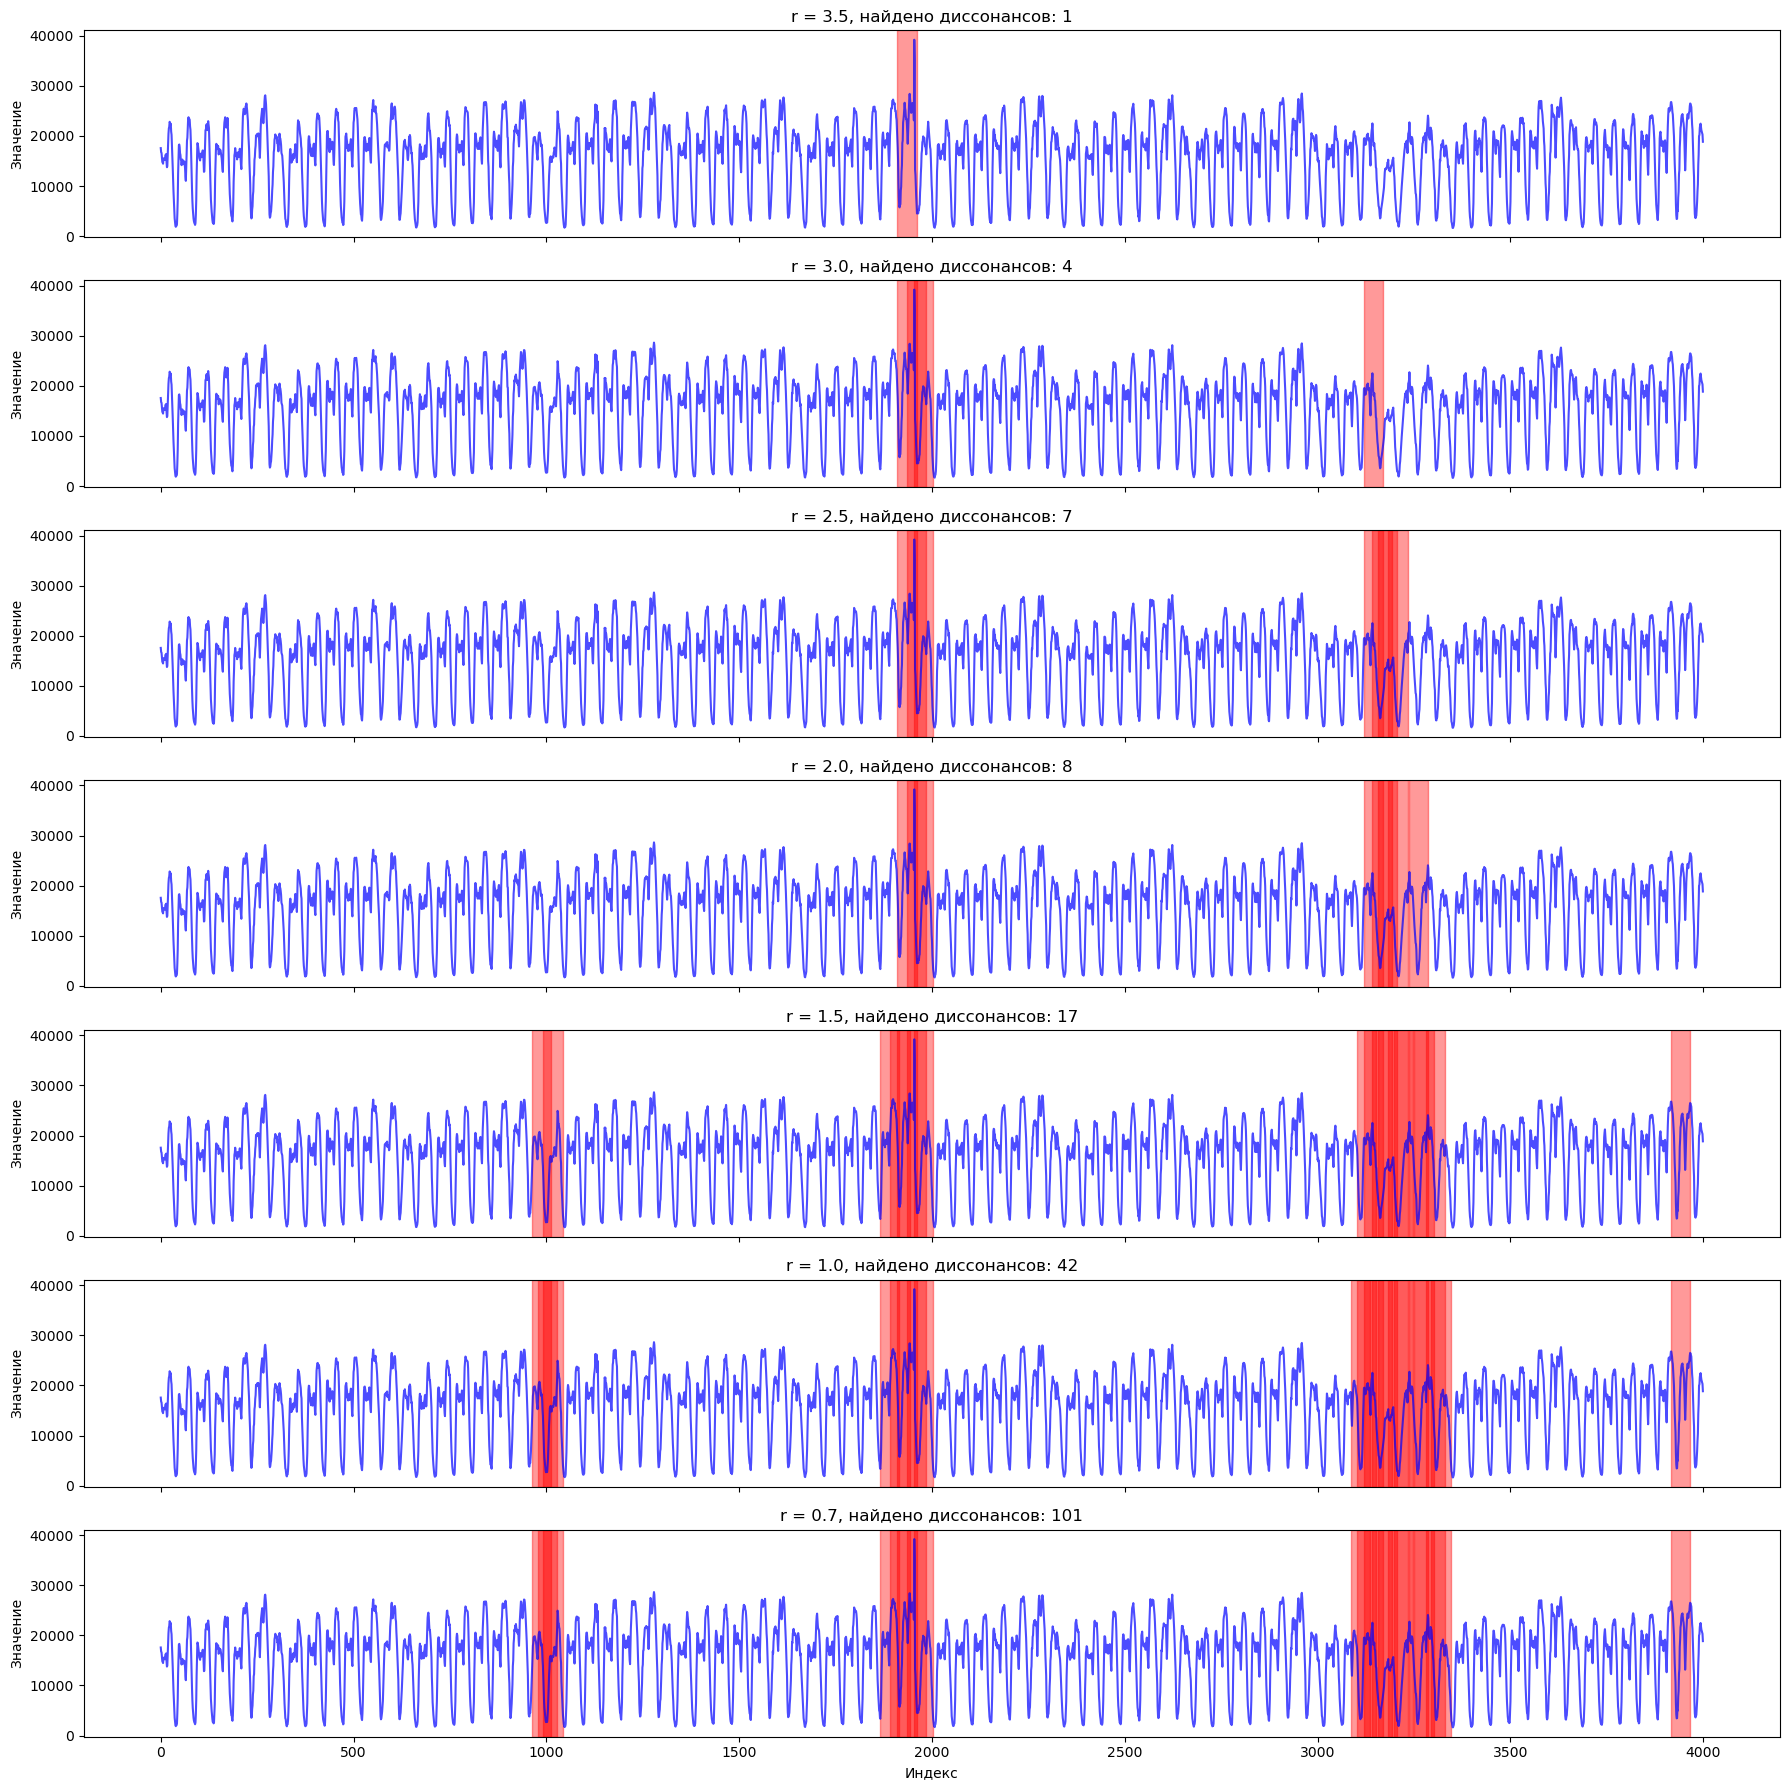

In [34]:
# Используем значения r в реальном диапазоне расстояний
m = 50
thresholds = [3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.7]

fig, axes = plt.subplots(figsize=(18, 18), nrows=len(thresholds), sharex=True)

for i, r in enumerate(thresholds):
    idxs, nn_dists, nn_idxs = DRAG(nyc_taxi, m, r)
    
    axes[i].plot(nyc_taxi, label='Временной ряд', alpha=0.7, color='blue')
    
    # Отмечаем найденные диссонансы
    for idx in idxs[:20]:
        axes[i].axvspan(idx, idx + m, alpha=0.4, color='red')
    
    axes[i].set_title(f'r = {r}, найдено диссонансов: {len(idxs)}')
    axes[i].set_ylabel('Значение')

axes[-1].set_xlabel('Индекс')
plt.tight_layout()
plt.show()

Пороговое значение r = 2.5
Количество найденных диссонансов: 7


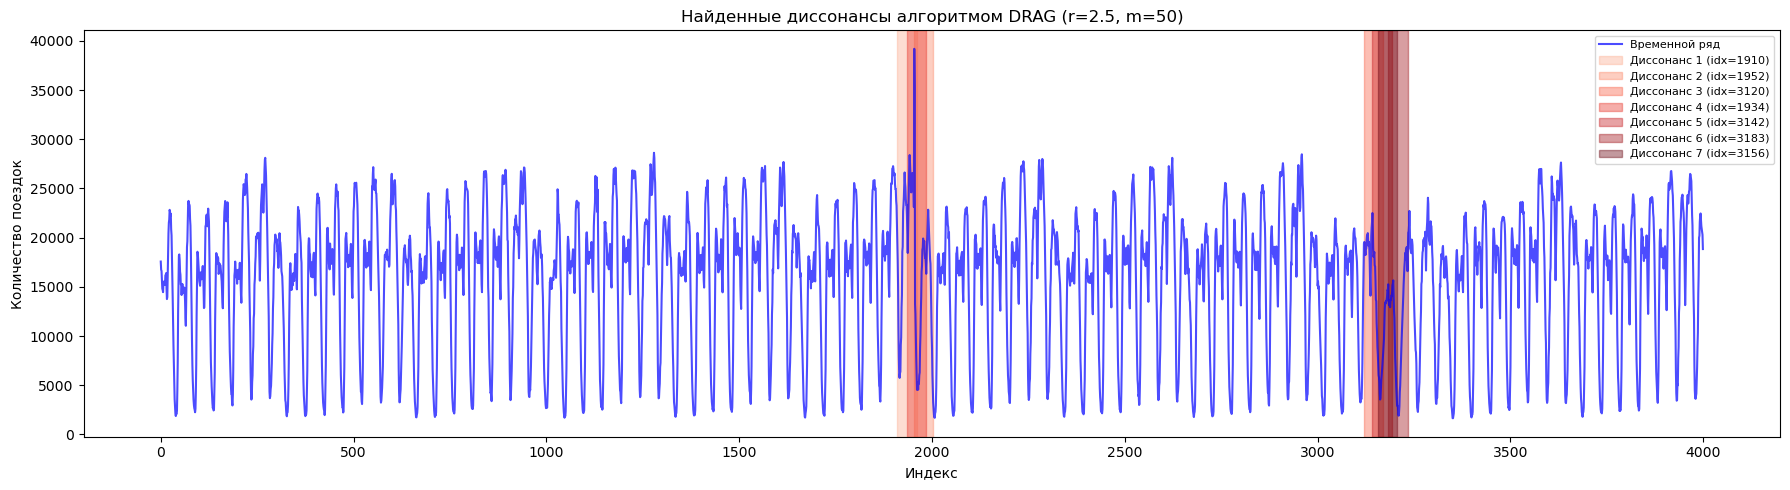

In [35]:
# Выбираем порог около верхнего квартиля расстояний
m = 50
r = 2.5  # между средним (0.76) и максимумом (3.53)

idxs, nn_dists, nn_idxs = DRAG(nyc_taxi, m, r)

print(f'Пороговое значение r = {r}')
print(f'Количество найденных диссонансов: {len(idxs)}')

# Визуализация
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(nyc_taxi, label='Временной ряд', color='blue', alpha=0.7)

colors = plt.cm.Reds(np.linspace(0.3, 1, min(10, len(idxs))))
for i, idx in enumerate(idxs[:10]):
    ax.axvspan(idx, idx + m, alpha=0.4, color=colors[i], 
               label=f'Диссонанс {i+1} (idx={idx})')

ax.set_xlabel('Индекс')
ax.set_ylabel('Количество поездок')
ax.set_title(f'Найденные диссонансы алгоритмом DRAG (r={r}, m={m})')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

In [36]:
# Сводная таблица с корректными значениями r
print("Сводная таблица экспериментов:")
print(f"{'m':<10} {'r':<10} {'Диссонансов':<15}")
print("-" * 35)

for m in [30, 50, 75]:
    for r in [3.0, 2.5, 2.0, 1.5, 1.0, 0.7, 0.5]:
        idxs, _, _ = DRAG(nyc_taxi, m, r)
        print(f"{m:<10} {r:<10.1f} {len(idxs):<15}")
    print()

Сводная таблица экспериментов:
m          r          Диссонансов    
-----------------------------------
30         3.0        2              
30         2.5        7              
30         2.0        12             
30         1.5        20             
30         1.0        58             
30         0.7        117            
30         0.5        170            

50         3.0        4              
50         2.5        7              
50         2.0        8              
50         1.5        17             
50         1.0        42             
50         0.7        101            
50         0.5        188            

75         3.0        8              
75         2.5        9              
75         2.0        13             
75         1.5        25             
75         1.0        67             
75         0.7        129            
75         0.5        156            



Чтобы разобраться, почему так происходит и как работает данный алгоритм, ниже мы реализуем все этапы алгоритма DRAG.

Как мы помним из лекций алгоритм DRAG содержит два этапа:

1. Отбор - За одно сканирование ряда сформировать множество кандидатов в диссонансы.
2. Очистка - За одно сканирование ряда отбросить кандидатов, которые являются ложными диссонансами.

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы выбираем из всего множества подпоследовательностей ряда такие, для которых расстояние до правых ближайших соседей больше параметра $r$.

In [17]:
#выбирем более реальное значение для порога
r = 3

In [18]:
T, M_T, Σ_T = core.preprocess(data, m)
#формируем массив длинной равной длине  исходного ряда - m + 1, 
#элемент массива является истинным, 
#в том случае если подпоследовательность является потенциальным кандидатом
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
#находим индексы потенциальных кандидатов
cand_index = np.flatnonzero(is_cands)

In [19]:
print(f'{len(cand_index)} {len(cand_index)/len(data)*100} %')

113 11.3 %


Во время отбора кандидатов нам удалось выделить около 113 подпоследовательностей(около 11.3%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидим, что большая часть потенциальных диссонансов расположена в районе смены активности. 
К сожалению пресутсвуют и ложные диссонансы, которые случайным образом попали в данный список.

Сформируйте график найденных диссонансов

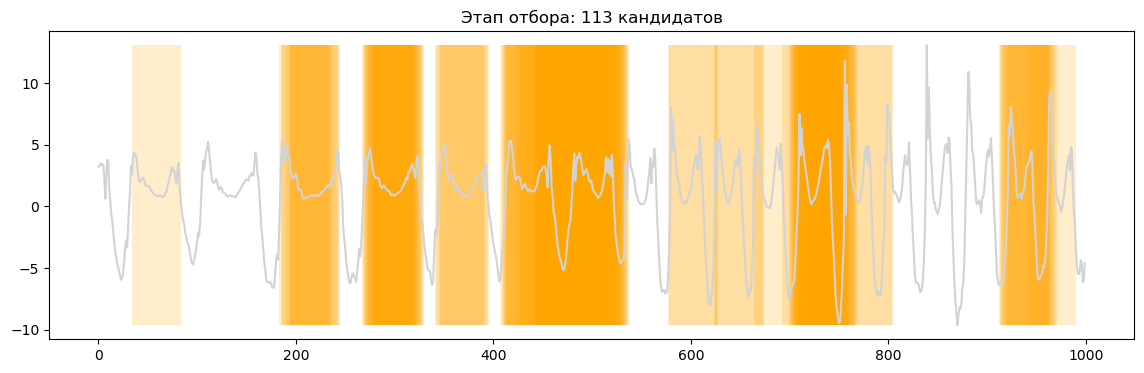

In [20]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(data, color='lightgray', label='Данные')
ax.set_title(f'Этап отбора: {len(cand_index)} кандидатов')

for idx in cand_index:
    rect = Rectangle((idx, np.min(data)), m, np.max(data)-np.min(data), facecolor='orange', alpha=0.2)
    ax.add_patch(rect)
plt.show()

##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 11.3% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с порогом $r$.


In [21]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [22]:
len(cands)/len(data)*100

2.9000000000000004

Сформируйте график найденных диссонансов

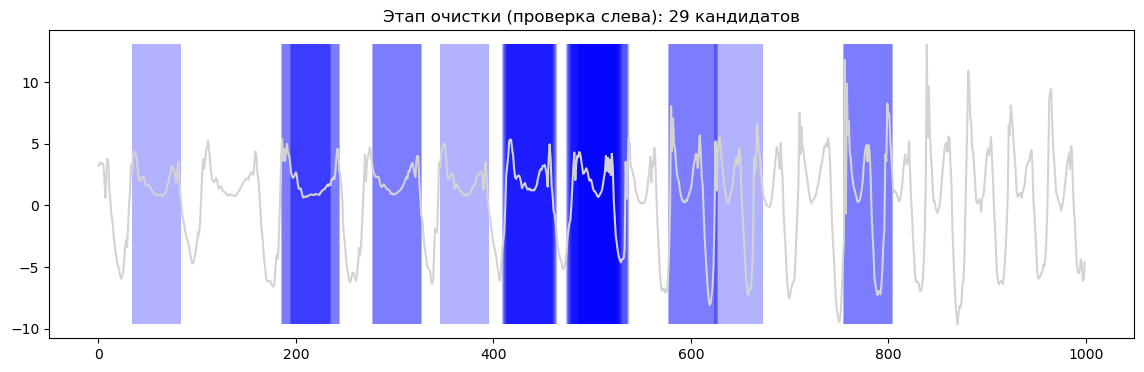

In [23]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(data, color='lightgray', label='Данные')
ax.set_title(f'Этап очистки (проверка слева): {len(cands)} кандидатов')

for idx in cands:
    rect = Rectangle((idx, np.min(data)), m, np.max(data)-np.min(data), facecolor='blue', alpha=0.3)
    ax.add_patch(rect)
plt.show()

Нам удалось сократить число диссонансов до 2.9%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [24]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

0.8999999999999999

Сформируйте график найденных диссонансов

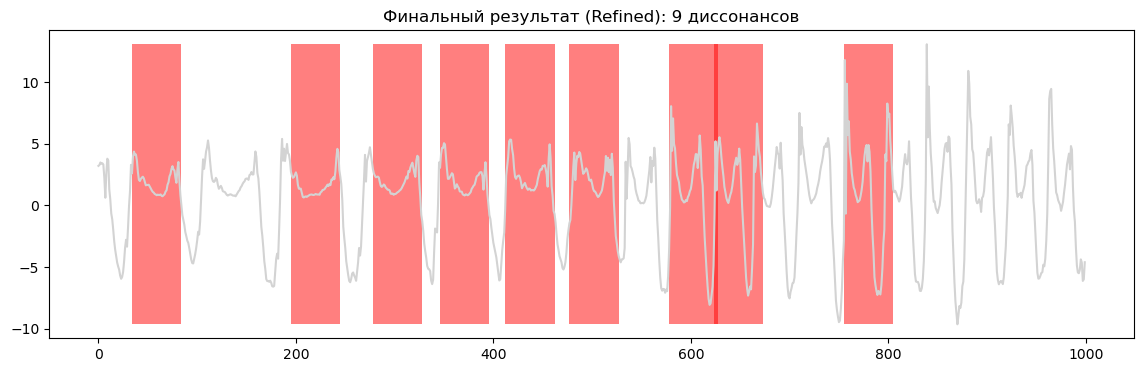

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(data, color='lightgray', label='Данные')
ax.set_title(f'Финальный результат (Refined): {len(discords_idx)} диссонансов')

for idx in discords_idx:
    rect = Rectangle((idx, np.min(data)), m, np.max(data)-np.min(data), facecolor='red', alpha=0.5)
    ax.add_patch(rect)
plt.show()

##### 3.2.3 Подбор параметров

Реализуйте перебор параметров $m$ и $r$. Подберете параметры таким образом, чтобы алгоритм обнаружил только те диссонансы, которые связаны со сменой активности. Сделайте вывод о том, как эти параметры влияют на качество работы модели.
Подберите оптимальные параметры алгоритма для набора данных такси NY. 
Визуализируйте результаты для разных комбинаций. Сделайте выводы.


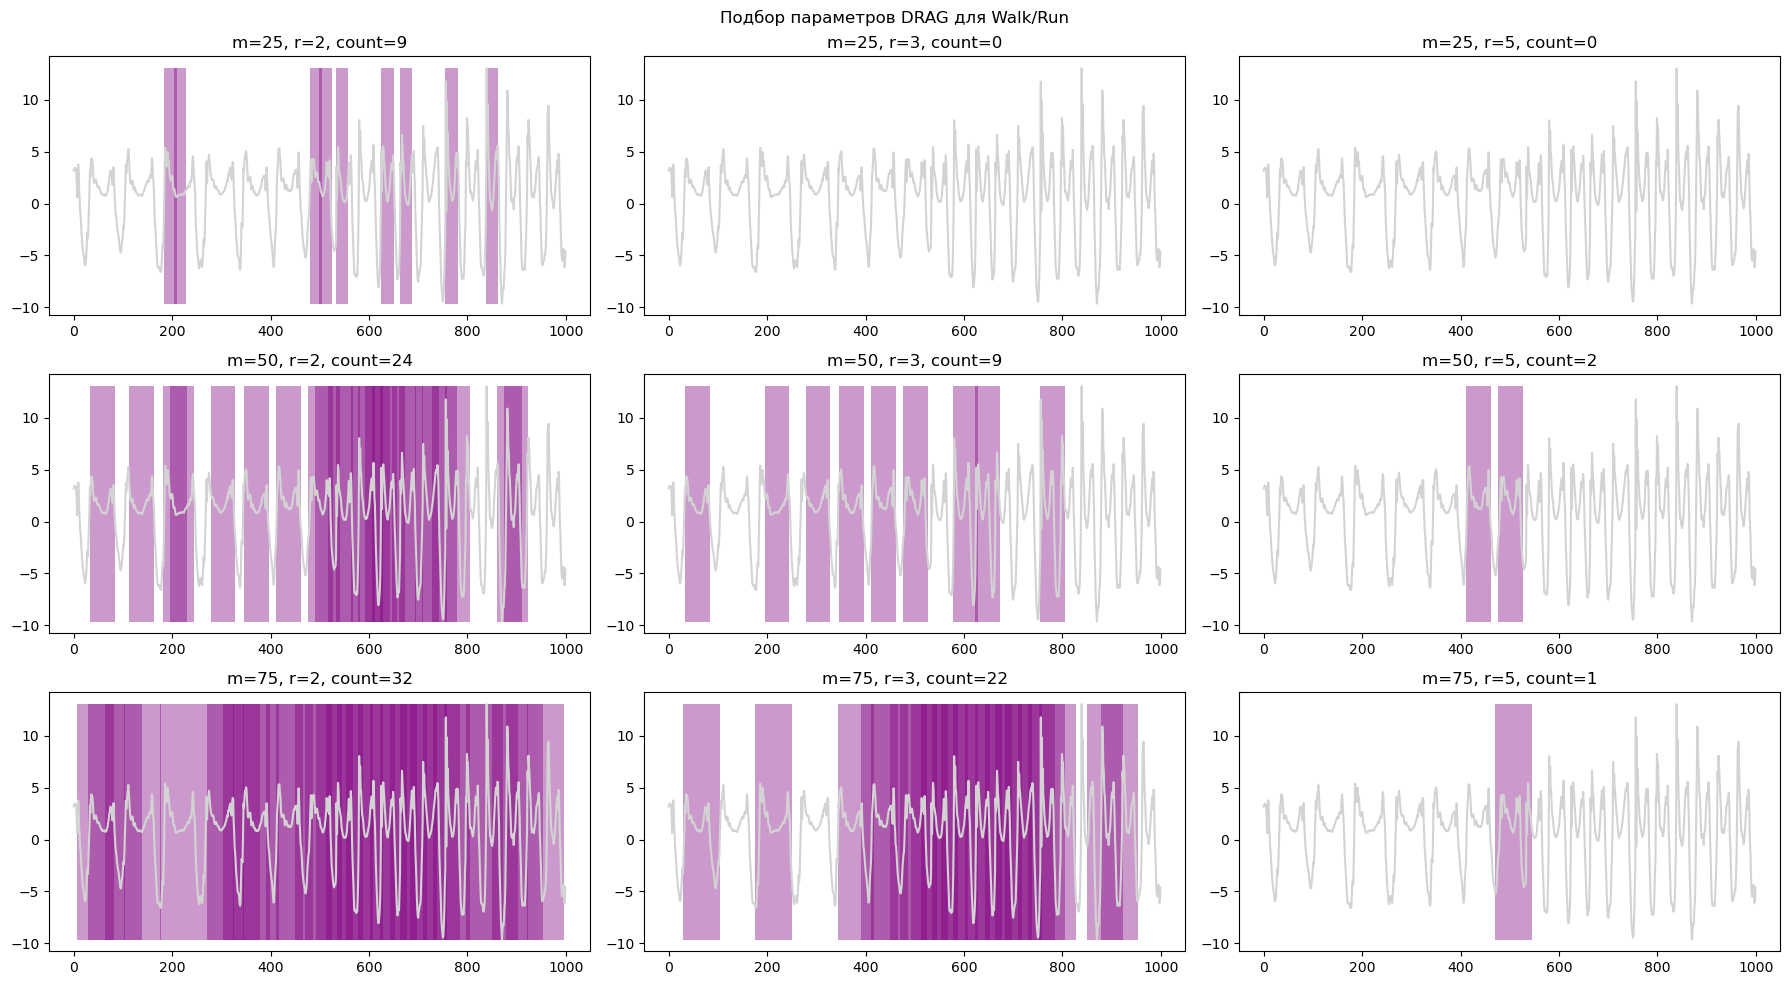

In [26]:
# Перебор параметров для Walk/Run
m_values = [25, 50, 75]
r_values = [2, 3, 5]

fig, axes = plt.subplots(len(m_values), len(r_values), figsize=(18, 10))
fig.suptitle('Подбор параметров DRAG для Walk/Run')

for i, m_val in enumerate(m_values):
    for j, r_val in enumerate(r_values):
        idxs, _, _ = DRAG(data, m_val, r_val)
        
        ax = axes[i, j]
        ax.plot(data, color='lightgray')
        for idx in idxs:
            rect = Rectangle((idx, np.min(data)), m_val, np.max(data)-np.min(data), facecolor='purple', alpha=0.4)
            ax.add_patch(rect)
        ax.set_title(f'm={m_val}, r={r_val}, count={len(idxs)}')

plt.tight_layout()
plt.show()

#### **3.3 Поиск диссонансов с помощью алгоритма Merlin**

Как мы уже выяснили подбирать параметры для DRAG простым перебором не очень удобно. Для оптимизации данного процесса в статье [1] был предложен алгоритм Merlin для оптимального поиска подходящего порогового значения.

Условно мы можем разделить поиск диссонансов на три шага:

1. Поиск диссонансов минимальной длинны $minL$. На данном шаге $r = 2\sqrt{minL}$.
2. Поиск диссонансов следующих четырех длин. На данном шаге $r = 0.99 \cdot nndist_{m-1}$. Где $nndist_{m-1}$ - расстояние до ближайшего соседа предыдущего найденного диссонанса.
3. Поиск диссонансов всех 
оставшихся дли. $r = \mu - 2 \sigma$. Средние значение и стандартное отклонение вычисляются из расстояний 5 предыдущих диссонансов. н

[1] Nakamura T., Imamura M., Mercer R., Keogh E.J. MERLIN: parameter-free discovery of arbitrary length anomalies in massive time series archives. 20th IEEE Int. Conf. on Data Mining, ICDM 2020, Sorrento, Italy, November 17-20, 2020. pp. 1190-1195. IEEE (2020). https://doi.org/10.1109/ICDM50108.2020.00147

##### 3.3.1 Поиск диссонансов минимальной длинны

Вспомнил последовательность действий первого шага алгоритма:
![merlin-part-first](pics/first_part.png)

В данной работе мы внесем небольшое изменение, мы будем считать, что подпоследовательность может быть диссонансом только в том случае, если больше 75% точек, не входят в состав других диссонансов. 

In [13]:
T = walk_run
m = 50
# сформируем массив метод для потенциальных кандидатов в диссонансы.
# после каждого найденного диссонанса, 
# мы будем исключать окружающие его подпоследовательности из числа потенциальных кандидатов,
# путем замены значений их меток на false
excl_zone = int(np.ceil(m / 4))
include = np.ones(len(T)-m+1, dtype=bool)
# Количество диссонансов, которые мы будем искать
topK = 10


In [14]:
dis_idx = -np.ones((topK))
dis_nnDist = -np.ones((topK))
dis_nn_idx = np.full((topK),-np.inf)
#первое прближение r
r = 2*np.sqrt(m)
minL = m
maxL = int(m+np.ceil(m*0.1))
#количество найденных диссонасов
cound_find_dis = 0

while dis_nnDist[cound_find_dis-1]<0 and cound_find_dis<topK:
    result = DRAG(data=T,m=minL,r=r, include =include)
    for diss, nnDist, nn in zip(*result):
        dis_idx[cound_find_dis] = diss
        dis_nnDist[cound_find_dis] = nnDist
        dis_nn_idx[cound_find_dis] = nn
        #исключаем окружающие найденный диссонас 
        #подпоследовательности и числа потенциальных диссонасов
        core.apply_exclusion_zone(include, diss, excl_zone, False)
        cound_find_dis+=1
        if cound_find_dis>=topK:
            break
    r*=0.5

In [15]:
maxL

55

In [16]:
print('Количество найденных на первом этапе диссонансов:', cound_find_dis)

Количество найденных на первом этапе диссонансов: 2


На первом шаге нам удалось выделить 2 диссонанса из 10 требуемых. 
Реализуйте, оставшиеся шаги алгоритма, чтобы найти оставшиеся диссонансы. 

![merlin-part-first](pics/second_part.png)


In [18]:
# Шаг 2: Поиск диссонансов для следующих 4 длин
# r = расстояние до ближайшего соседа предыдущего диссонанса

current_length = minL + 1
step2_lengths = 4  # количество длин для шага 2

for _ in range(step2_lengths):
    if cound_find_dis >= topK:
        break
    
    # r = расстояние предыдущего диссонанса
    r = dis_nnDist[cound_find_dis - 1]
    if r <= 0:
        r = 2 * np.sqrt(current_length)
    
    excl_zone = int(np.ceil(current_length / 4))
    
    # Поиск диссонансов для текущей длины
    found = False
    while not found and cound_find_dis < topK:
        include_len = len(T) - current_length + 1
        if include_len <= 0:
            break
        
        result = DRAG(data=T, m=current_length, r=r, include=include[:include_len])
        
        if len(result[0]) > 0:
            for diss, nnDist, nn in zip(*result):
                dis_idx[cound_find_dis] = diss
                dis_nnDist[cound_find_dis] = nnDist
                dis_nn_idx[cound_find_dis] = nn
                core.apply_exclusion_zone(include, diss, excl_zone, False)
                cound_find_dis += 1
                if cound_find_dis >= topK:
                    break
            found = True
        else:
            r *= 0.5
            if r < 1e-10:
                break
    
    current_length += 1

print(f'После шага 2 найдено диссонансов: {cound_find_dis}')

После шага 2 найдено диссонансов: 10


In [19]:
# Шаг 3: Поиск диссонансов для оставшихся длин
# r = mean + std из 5 предыдущих диссонансов

while cound_find_dis < topK and current_length <= maxL:
    # Вычисляем r из последних 5 диссонансов
    start_idx = max(0, cound_find_dis - 5)
    recent_dists = dis_nnDist[start_idx:cound_find_dis]
    valid_dists = recent_dists[recent_dists > 0]
    
    if len(valid_dists) > 0:
        mean_d = np.mean(valid_dists)
        std_d = np.std(valid_dists)
        r = mean_d + std_d
    else:
        r = 2 * np.sqrt(current_length)
    
    excl_zone = int(np.ceil(current_length / 4))
    
    found = False
    while not found and cound_find_dis < topK:
        include_len = len(T) - current_length + 1
        if include_len <= 0:
            break
        
        result = DRAG(data=T, m=current_length, r=r, include=include[:include_len])
        
        if len(result[0]) > 0:
            for diss, nnDist, nn in zip(*result):
                dis_idx[cound_find_dis] = diss
                dis_nnDist[cound_find_dis] = nnDist
                dis_nn_idx[cound_find_dis] = nn
                core.apply_exclusion_zone(include, diss, excl_zone, False)
                cound_find_dis += 1
                if cound_find_dis >= topK:
                    break
            found = True
        else:
            r *= 0.5
            if r < 1e-10:
                break
    
    current_length += 1

print(f'Итого найдено диссонансов: {cound_find_dis}')

Итого найдено диссонансов: 10


In [20]:
# Вывод найденных диссонансов
print("\nНайденные диссонансы:")
print(f"{'№':<4} {'Индекс':<10} {'NN расстояние':<15} {'Индекс NN':<10}")
print("-" * 45)
for i in range(cound_find_dis):
    print(f"{i+1:<4} {int(dis_idx[i]):<10} {dis_nnDist[i]:<15.4f} {int(dis_nn_idx[i]):<10}")


Найденные диссонансы:
№    Индекс     NN расстояние   Индекс NN 
---------------------------------------------
1    477        5.8810          701       
2    412        5.3270          346       
3    195        3.4388          112       
4    576        3.3045          530       
5    623        3.1355          754       
6    32         3.1317          344       
7    344        3.1317          32        
8    755        3.1248          796       
9    113        3.1130          276       
10   277        3.0928          114       


Найдите диссонансы набора такси NY. Визуализируйте найденные диссонансы для обоих наборов данных, сравните с результатами остальных методов. 


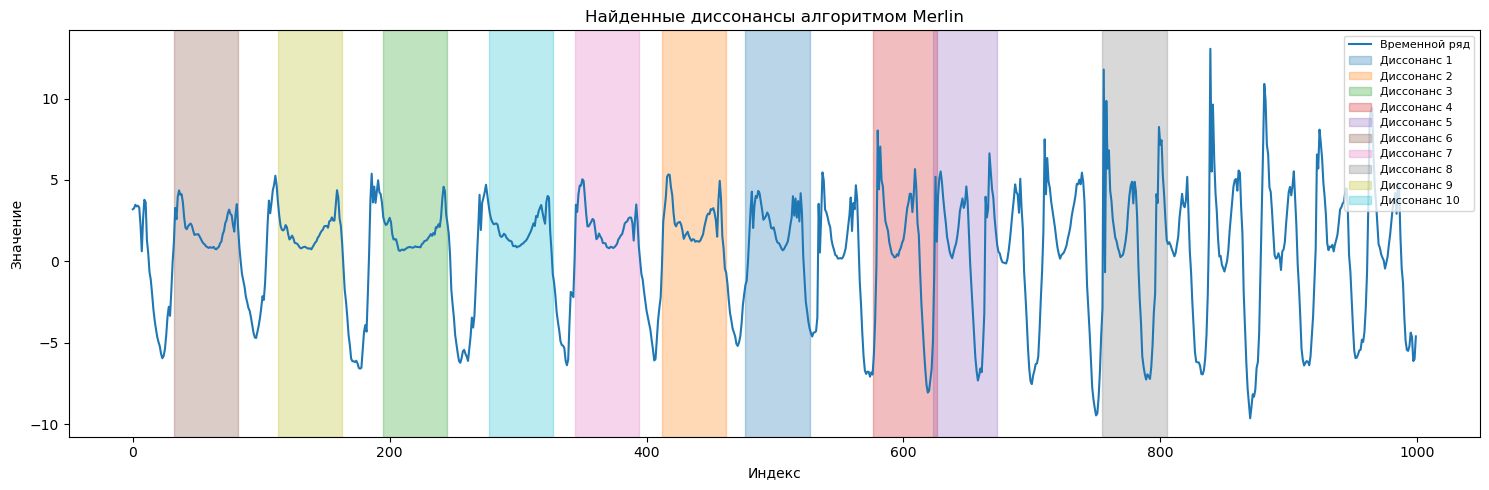

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(T, label='Временной ряд')

# Отмечаем найденные диссонансы разными цветами
colors = plt.cm.tab10(np.linspace(0, 1, int(cound_find_dis)))
for i in range(int(cound_find_dis)):
    idx = int(dis_idx[i])
    ax.axvspan(idx, idx + m, alpha=0.3, color=colors[i], label=f'Диссонанс {i+1}')

ax.set_xlabel('Индекс')
ax.set_ylabel('Значение')
ax.set_title('Найденные диссонансы алгоритмом Merlin')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()